In [1]:
#necessary imports

import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import unquote
import numpy as np
import plotly.express as px

# To Extract all the URLs from the HTM page
from bs4 import BeautifulSoup
import os

import networkx as nx
from datetime import datetime

# Draw the graph
import seaborn as sns

from helpers import (
    extract_links,
    change_characters,
    path_to_name,
    get_gender_for_name,
    add_all_genders,
    get_dict_from_list,
    update_dict_with_counts,
    replace_to_simple,
    create_dict_for_plotly_bar
    )   
%load_ext autoreload


/Users/louisefont/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## NDLM'ADA - Look up ! Stars and how we them
##### *Timo Achard, Romane Clerc, Louise Font, Julie Korber, Emeric Martin*

# Table of contents
* [Data Explanation](#section1)
    * [General pre processing](#sub_section_1_1)
    * [Data repartition](#sub_section_1_2)
        * [Article categories](#sub_section_1_2_1)
        * [People categories](#sub_section_1_2_2)
    * [Gender retrieval](#sub_section_1_3)
        * [Gender repartition in categories](#sub_section_1_3_1)
    * [Graph connection and article representation](#sub_section_1_4)

* [Page Rank](#section2)
    * [General results](#sub_section_2_1)
    * [PageRank and gender](#sub_section_2_2)
* [Links analysis](#section3)
    * [Get the data](#sub_section_3_1)
    * [Distribution of last path](#sub_section_3_2)
    * [Plot the paths](#sub_section_3_3)
* [Influence of link position](#section4)
    * [Distribution of position](#sub_section_4_1)
    * [Distribution influence](#sub_section_4_2)
* [Influence of genre](#section5)
    * [Unbalanced data](#sub_section_5_1)
    * [Birth data explanation](#sub_section_5_2)


## 1. Data Explanation <a classe="anchor" id="Section1"></a>

### 1.1 General pre processing <a id="sub_section_1_1"></a>

In [2]:


# Colors definition for beautiful graphs

# Gender colors were inspired by this article : https://www.telegraph.co.uk/women/business/women-mean-business-interactive/
color_male = '#0acc65'
color_female = '#9904de'
color_unknown = 'grey'
colors_gender = [color_male, color_female, color_unknown]

colors_categories = ["#F3C300",
                      "#875692",
                      "#F38400",
                      "#A1CAF1",
                      "#BE0032",
                      "#C2B280",
                      "#848482",
                      "#008856",
                      "#E68FAC",
                      "#0067A5",
                      "#F99379",
                      "#604E97",
                      "#F6A600",
                      "#B3446C",
                      "#DCD300",
                      "#882D17",
                      "#8DB600",
                      "#654522",
                      "#E25822",
                      "#2B3D26"] # <- Tried to have colorblind-friendly colors (unsure about having 20 different colors, even for non-colorblind people...)

color_dict = {'Science':'#48b059', 'Geography':'#3d8039', 'People':'#b44624','History':'#ff8544','Everyday_life':'#e25d90', 'Design_and_Technology':'#8b1e9c','Countries':'#a7d145','Citizenship':'#fced3e', 'Language_and_literature':'#6bc6ff', 'Religion':'#1d59a8', 'Music':'#ffa7dc', 'Business_Studies':'#ffec6f','IT':'#008756','Mathematics':'#6bffce','Art':'#e0025e'}


### Downloading the dataset

In [3]:
# Paths
folder_path = "dataset/wikispeedia_paths-and-graph/"
file_paths = ["paths_finished.tsv", "paths_unfinished.tsv", "categories.tsv", "articles.tsv", "links.tsv"]

# Datasets: Names and their columns name
data_frames_names = ["paths_finished", "paths_unfinished", "categories", "article", "links"]
dfs_headers = [
    ["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"],
    ["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
    ["article", "category"],
    ["article"],
    ["linkSource", "linkTarget"]
]

# Download
dfs_skiprows = [16, 17, 13, 12, 12]
dfs = {}
for i in range(len(file_paths)):
    dfs[data_frames_names[i]] = pd.read_csv(folder_path + file_paths[i], sep='\t', header=None, names=dfs_headers[i], skiprows=range(dfs_skiprows[i]))

In [4]:
# renaming and adjustments

dfs = change_characters(dfs, 'paths_finished', 'path')
dfs['paths_finished'] = dfs['paths_finished'].drop(['hashedIpAddress', 'rating'], axis = 1)
dfs = change_characters(dfs, 'paths_unfinished', 'path')
dfs = change_characters(dfs, 'paths_unfinished', 'target')
dfs = change_characters(dfs, 'categories', 'article')
dfs = change_characters(dfs, 'categories', 'category')
categories = dfs['categories']
dfs = change_characters(dfs, 'article', 'article')
dfs = change_characters(dfs, 'links', 'linkSource')
dfs = change_characters(dfs, 'links', 'linkTarget')

### 1.2 Data repartition <a id="sub_section_1_2"></a>

#### 1.2.1 Article categories <a id="subsection_1_2_1"></a>

In [5]:
# First copy the data_frame
reduced_categories = categories.copy(deep=True)

# Extract the reduced categories and add them to the copied df
reduced_categories_list = [category.replace('subject.', '').split('.')[0] for category in reduced_categories['category']]
reduced_categories = reduced_categories.assign(first_category = reduced_categories_list)

# Extract second most important category
reduced_categories_list_2 = [category.replace('subject.', '').split('.')[1] if len(category.replace('subject.', '').split('.')) > 1 else None for category in reduced_categories['category']]
reduced_categories = reduced_categories.assign(second_category = reduced_categories_list_2)

# Count the new distribution and plot it
first_category_distribution = reduced_categories['first_category'].value_counts()
second_category_distribution = reduced_categories['second_category'].value_counts()
reduced_categories = reduced_categories.drop(columns =['article', 'category']).drop_duplicates()

merged = pd.merge(second_category_distribution, reduced_categories, on = 'second_category')
#display(merged.head())

fig = px.bar(merged, x="first_category", y="count", color="second_category", title="Categories represented in our dataset")
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()
fig.write_html("docs/overall_dataset_bar.html")

#### 1.2.2 People categories <a id="subsection_1_2_2"></a>

##### Extracting people data

In [6]:

# Selection of all the articles from a people category
all_people_selection = categories[categories['category'].str.contains('People')]

# Separate the data as people that are main or secondary people
main_people_selection = all_people_selection[all_people_selection['category'].str.contains('subject.People')]
second_people_selection = pd.concat([main_people_selection,all_people_selection]).drop_duplicates(keep=False)

# Verify that all the articles are unique
all_people_selection.info() 
main_people_selection.info()
second_people_selection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 1 to 5200
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   article   711 non-null    object
 1   category  711 non-null    object
dtypes: object(2)
memory usage: 16.7+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 689 entries, 1 to 5200
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   article   689 non-null    object
 1   category  689 non-null    object
dtypes: object(2)
memory usage: 16.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 250 to 4806
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   article   22 non-null     object
 1   category  22 non-null     object
dtypes: object(2)
memory usage: 528.0+ bytes


In [7]:
# Count for each people category
people_categories = pd.DataFrame(main_people_selection.value_counts('category'))
people_categories.index = [cat.replace('subject.People.', '') for cat in people_categories.index]
people_categories['category'] = people_categories.index

# Do a beautiful plot
fig = px.bar_polar(people_categories, r="count", theta="category", color= colors_categories)
fig.update_layout(showlegend=False)
fig.show()
#Export html for the website
fig.write_html("docs/people_categories.html")



### 1.3 Gender retrieval <a id="sub_section_1_3"></a>

In [8]:
#to run the script from raw
#main_people_selection = add_all_genders(main_people_selection)

#to download from stored file 
main_people_selection_path = 'dataset/people_selection.json'
main_people_selection = pd.read_json(main_people_selection_path, orient = 'records', lines = True)
main_people_selection = main_people_selection.set_index('article')

#### 1.3.1 Gender repartition in categories <a id="subsection_1_3_1"></a>

In [9]:
#group all people by their gender and category into a new dataframe

people_gender = pd.DataFrame(main_people_selection.groupby(['category', 'gender']).size().unstack(fill_value=0))
people_gender.index = [cat.replace('subject.People.', '') for cat in people_gender.index]
people_gender['category'] = people_gender.index
people_gender = people_gender.reset_index(drop = True, names = 'index')
people_gender.head()

gender,Female,Male,Unknown,category
0,11,12,2,Actors_models_and_celebrities
1,1,35,0,Artists
2,0,21,0,Astronomers_and_physicists
3,1,7,0,Chemists
4,0,9,0,Computing_People


In [10]:
people_gender = pd.DataFrame(main_people_selection.groupby(['category', 'gender']).size().unstack(fill_value=0))
people_gender.index = [cat.replace('subject.People.', '') for cat in people_gender.index]
people_gender['category'] = people_gender.index
people_gender

gender,Female,Male,Unknown,category
Actors_models_and_celebrities,11,12,2,Actors_models_and_celebrities
Artists,1,35,0,Artists
Astronomers_and_physicists,0,21,0,Astronomers_and_physicists
Chemists,1,7,0,Chemists
Computing_People,0,9,0,Computing_People
Engineers_and_inventors,0,24,1,Engineers_and_inventors
Geographers_and_explorers,0,19,2,Geographers_and_explorers
Historical_figures,9,93,6,Historical_figures
Human_Scientists,4,19,0,Human_Scientists
Mathematicians,0,15,0,Mathematicians


In [11]:
fig = px.bar(people_gender, x='category', y=["Male", 'Female', "Unknown"], title="Men and women in our dataset", color_discrete_sequence=[color_male,color_female,color_unknown])
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()
fig.write_html("docs/overall_categories_gender.html")

### 1.4 Graph connection and article representation <a id="sub_section_1_4"></a>

## 2 Page Rank <a id="section2"></a>

### 2.1 General results <a id="sub_section_2_1"></a>

### 2.2 Page Rank and gender <a id="sub_section_2_2"></a>


## 3 Links analysis <a id="section3"></a>


### 3.1 Get the data <a id="sub_section_3_1"></a>


In [12]:
# some helper functions

# adds a column to a dataset to give the main category of last article in a path
def get_end_cat(art):
    return main_people_selection.reset_index().loc[main_people_selection.reset_index()['article'] == art, 'category'].iloc[0].replace('subject.','')

# simplifies the path to transform it to a list and delete useless information
def transform_path(path):
    split_path = path.split(';')
    split_cat = []
    for art in split_path:
        if art != '<' : 
            try: split_cat.append(categories.loc[categories['article'] == art, 'category'].iloc[0].replace('subject.', ''))
            except IndexError : print('Warning: not valid article:', art)
    return split_cat


In [13]:
# first lets retrieve all the paths and prepare them to be analysed
paths_finished = dfs['paths_finished']
paths = paths_finished.drop(['timestamp','durationInSec'], axis = 1)

paths['end'] = [path.split(';')[-1] for path in paths['path']]
paths['path_cat'] = [transform_path(path) for path in paths['path']]
paths.head(10)

,path,end,path_cat
0,14th_century;15th_century;16th_century;Pacific...,African_slave_trade,"[History.General_history, History.General_hist..."
1,14th_century;Europe;Africa;Atlantic_slave_trad...,African_slave_trade,"[History.General_history, Geography.European_G..."
2,14th_century;Niger;Nigeria;British_Empire;Slav...,African_slave_trade,"[History.General_history, Geography.African_Ge..."
3,14th_century;Renaissance;Ancient_Greece;Greece,Greece,"[History.General_history, History.General_hist..."
4,14th_century;Italy;Roman_Catholic_Church;HIV;R...,John_F._Kennedy,"[History.General_history, Countries, Religion...."
5,14th_century;Europe;North_America;United_State...,John_F._Kennedy,"[History.General_history, Geography.European_G..."
6,14th_century;China;Gunpowder;Fire,Fire,"[History.General_history, Geography.Geography_..."
7,14th_century;Time;Isaac_Newton;Light;Color;Rai...,Rainbow,"[History.General_history, Science.Physics.Gene..."
8,14th_century;Time;Light;Rainbow,Rainbow,"[History.General_history, Science.Physics.Gene..."
9,14th_century;15th_century;Plato;Nature;Ultravi...,Rainbow,"[History.General_history, History.General_hist..."


In [14]:
# now let's focus on solely the paths

paths_only = paths['path_cat']
paths_only = [path[-4:] for path in paths_only]
paths_only_simple = [replace_to_simple(path) for path in paths_only]

# create a dictionnary that containts the paths leading to each category

path_dict = {}
for category in first_category_distribution.index:
    cat_path = [path for path in paths_only_simple if path[-1]==category]
    path_dict[category]=cat_path

# create a dictionnary with supplementary data for all paths

new_path_dict = update_dict_with_counts(path_dict)

### 3.2 Get the data distribution <a id="sub_section_3_2"></a>

In [15]:
#combine everything in a single dataframe

dict_for_bar_plot = {key:create_dict_for_plotly_bar(new_path_dict[key]) for key in new_path_dict.keys()}

### Now let's get some more specific data as well

#### Now let's do this same plot but comparing women and men in the people category 

In [16]:
main_people_selection_new = main_people_selection.reset_index()
main_people_selection_new = main_people_selection_new.rename(columns={'article':'end'})

people_path = paths.loc[paths['end'].isin(main_people_selection.index)]
people_path = pd.merge(people_path, main_people_selection_new, on = 'end', how = 'left')
path_male = people_path.loc[people_path['gender'] == 'Male']
path_female = people_path.loc[people_path['gender'] == 'Female']

paths_only_male = path_male['path_cat']
paths_only_male = [path[-4:] for path in paths_only_male]
paths_only_simple_male = [replace_to_simple(path) for path in paths_only_male]
male_dict = get_dict_from_list(paths_only_simple_male)

paths_only_female = path_female['path_cat']
paths_only_female = [path[-4:] for path in paths_only_female]
paths_only_simple_female = [replace_to_simple(path) for path in paths_only_female]
female_dict = get_dict_from_list(paths_only_simple_female)

female_dict = create_dict_for_plotly_bar(female_dict)
male_dict = create_dict_for_plotly_bar(male_dict)

#### And now if we focus only on celebrities

In [17]:
path_actors = [path for path in people_path['path_cat'] if path[-1].split('.')[1] == 'Actors_models_and_celebrities']
path_actors = [path[-4:] for path in path_actors]
path_actors = [replace_to_simple(path) for path in path_actors]
actors_dict = get_dict_from_list(path_actors)
actors_dict = create_dict_for_plotly_bar(actors_dict)

In [ ]:
people_path['simple_cat'] = [path.split('.')[-1] for path in people_path['category']]
actors_path = people_path.loc[people_path['simple_cat'] == 'Actors_models_and_celebrities']

path_male_actors = people_path.loc[people_path['gender'] == 'Male']
path_female_actors = people_path.loc[people_path['gender'] == 'Female']

paths_only_male_actors = path_male_actors['path_cat']
paths_only_male_actors = [path[-4:] for path in paths_only_male_actors]
paths_only_simple_male_actors = [replace_to_simple(path) for path in paths_only_male_actors]
male_dict_actors = get_dict_from_list(paths_only_simple_male_actors)

paths_only_female_actors = path_female_actors['path_cat']
paths_only_female_actors = [path[-4:] for path in paths_only_female_actors]
paths_only_simple_female_actors = [replace_to_simple(path) for path in paths_only_female_actors]
female_dict_actors = get_dict_from_list(paths_only_simple_female_actors)

female_dict_actors = create_dict_for_plotly_bar(female_dict_actors)
male_dict_actors = create_dict_for_plotly_bar(male_dict_actors)

In [18]:
specific_dict = {'women':female_dict, 'men':male_dict, 'actors, models and celebrities':actors_dict, 'female actors': female_dict_actors, 'male actors': male_dict_actors}

NameError: name 'female_dict_actors' is not defined

#### Now let's combine it all together

In [ ]:
dict_for_bar_plot.update(specific_dict)

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

app = dash.Dash(__name__)
app.layout = html.Div([
    dcc.Dropdown(id='dic_dropdown', options = [{'label': key, 'value': key} for key in dict_for_bar_plot.keys()], value='Science', style={'width':'50%'}),
    dcc.Graph(id='bar_chart')
])

@app.callback(
    Output('bar_chart', 'figure'),
    [Input('dic_dropdown', 'value')]
)

def update_chart(category):
    selected_data_dict = dict_for_bar_plot[category]

    # Create a bar chart using Plotly Express
    fig = px.bar(selected_data_dict, x='category', y=['count_N1', 'count_N2', 'count_N3'], title="Categories in the path leading to final article in " + str(category), color_discrete_sequence=colors_gender)
    fig.update_layout(barmode='group', xaxis={'categoryorder':'total descending'})

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

#fig.write_html("docs/path_categories_dropdown.html")

### 3.3 Plot the paths <a id="sub_section_3_3"></a>

In [ ]:
# for a clean legend

from matplotlib.lines import Line2D

color_dict = {'Science':'#48b059', 'Geography':'#3d8039', 'People':'#b44624','History':'#ff8544','Everyday_life':'#e25d90', 'Design_and_Technology':'#8b1e9c','Countries':'#a7d145','Citizenship':'#fced3e', 'Language_and_literature':'#6bc6ff', 'Religion':'#1d59a8', 'Music':'#ffa7dc', 'Business_Studies':'#ffec6f','IT':'#008756','Mathematics':'#6bffce','Art':'#e0025e'}

custom_color_lines = [Line2D([0], [0], color='#48b059', lw=4),
                Line2D([0], [0], color='#3d8039', lw=4),
                Line2D([0], [0], color='#b44624', lw=4),
                Line2D([0], [0], color='#ff8544', lw=4),
                Line2D([0], [0], color='#e25d90', lw=4),
                Line2D([0], [0], color='#8b1e9c', lw=4),
                Line2D([0], [0], color='#a7d145', lw=4),
                Line2D([0], [0], color='#fced3e', lw=4),
                Line2D([0], [0], color='#6bc6ff', lw=4),
                Line2D([0], [0], color='#1d59a8', lw=4),
                Line2D([0], [0], color='#ffa7dc', lw=4),
                Line2D([0], [0], color='#ffec6f', lw=4),
                Line2D([0], [0], color='#008756', lw=4),
                Line2D([0], [0], color='#6bffce', lw=4),
                Line2D([0], [0], color='#e0025e', lw=4)]
custom_color_labels = color_dict.keys()

In [ ]:
def plot_path(path_dict, category):
    print(category)
    line_width = 10/len(path_dict[category])
    for path in path_dict[category]['long_path_list']:
        if len(path) > 1:
            x_path = np.arange(start = 4 - len(path), stop = 4, step = 1)
            plt.plot(x_path, path,color = color_dict[path[-2]], alpha = 0.01)
    annotations_N1 = path_dict[category]['N1']['count'].tolist()
    x_N1 = np.full(len(path_dict[category]['N1']), 2).tolist()
    y_N1 = path_dict[category]['N1']['category'].tolist()
    for i, annotation in enumerate(annotations_N1):
        plt.annotate(str(annotation), (x_N1[i], y_N1[i]), fontsize = 6, color = 'grey')
    annotations_N2 = path_dict[category]['N2']['count'].tolist()
    x_N2 = np.full(len(path_dict[category]['N2']), 1).tolist()
    y_N2 = path_dict[category]['N2']['category'].tolist()
    for i, annotation in enumerate(annotations_N2):
        plt.annotate(str(annotation), (x_N2[i], y_N2[i]), fontsize = 6, color = 'grey')
    annotations_N3 = path_dict[category]['N3']['count'].tolist()
    x_N3 = np.full(len(path_dict[category]['N3']), 0).tolist()
    y_N3 = path_dict[category]['N3']['category'].tolist()
    for i, annotation in enumerate(annotations_N3):
        plt.annotate(str(annotation), (x_N3[i], y_N3[i]), fontsize = 6, color = 'grey')
    
    plt.title(category, size = 14)
    plt.xticks(np.arange(4), ['N-3', 'N-2', 'N-1', 'N'])
    plt.tick_params(labelsize = 10)
    plt.legend(custom_color_lines, custom_color_labels, loc = 'upper left', bbox_to_anchor = (1,1))
    plt.show()

Science


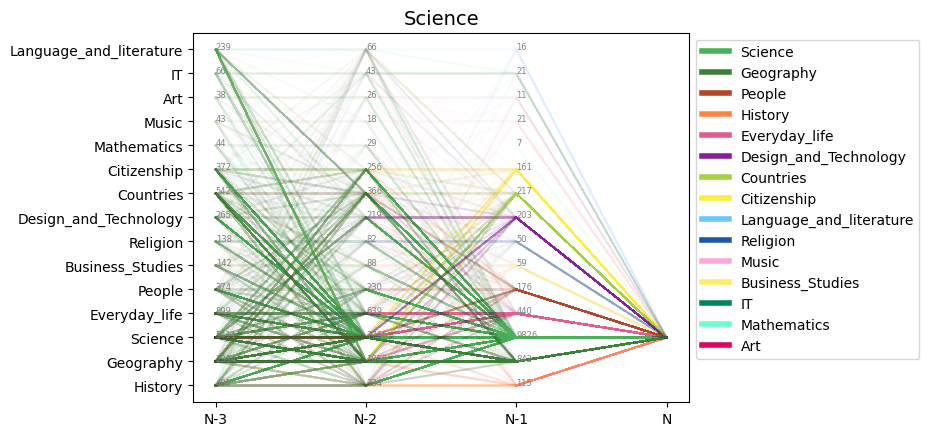

In [ ]:
plot_path(new_path_dict, 'Science')

## 4 Influence of link position <a id="section4">


### 4.1 Distribution of position <a id="sub_section_4_1"></a>


### 4.2 Distribution of influence <a id="sub_section_4_2"></a>


## 5 Influence of genre <a id="section5"></a>


### 5.1 Unbalanced data <a id="sub_section_5_1"></a>


First let's get the number of people in starting position and finishing position of the paths.

In [44]:
#get all starting points
starting_points = pd.DataFrame([path.split(';')[0] for path in paths_finished['path']], columns=['article'])
finishing_points = pd.DataFrame([path.split(';')[-1] for path in paths_finished['path']], columns=['article'])

#keep only those about people
starting_points = starting_points.loc[starting_points['article'].isin(main_people_selection.reset_index()['article'])]
finishing_points = finishing_points.loc[finishing_points['article'].isin(main_people_selection.reset_index()['article'])]

#get their gender
main_people_selection_single = main_people_selection.reset_index().drop_duplicates(subset = ['article'], keep='first').set_index('article')
starting_points['gender'] = [main_people_selection_single.loc[person]['gender'] for person in starting_points['article']]
finishing_points['gender'] = [main_people_selection_single.loc[person]['gender'] for person in finishing_points['article']]

In [47]:
starting_counts = starting_points.groupby(['gender']).count().reset_index()
finishing_counts = finishing_points.groupby(['gender']).count().reset_index()

In [57]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=starting_counts['gender'], values=starting_counts['article'], name="starting"),
              1, 1)
fig.add_trace(go.Pie(labels=finishing_counts['gender'], values=finishing_counts['article'], name="finishing"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4)

fig.update_layout(title_text="Total number of people in paths and their gender distribution")
fig.show()

### 5.2 Birth of date explanation <a id="sub_section_5_2"></a>